In [6]:
import os
import pandas  as pd #Data manipulation
import numpy as np #Data manipulation
import matplotlib.pyplot as plt # Visualization
import seaborn as sns #Visualization
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/datasets/

Based on the analysis from https://www.kaggle.com/code/sudhirnl7/linear-regression-tutorial

In [11]:
# Load data
df = pd.read_csv('insurance.csv')

/content/drive/My Drive/datasets


# Data exploration

In [13]:
print(df.head())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [ ]:
# Data exploration
#  Start by understanding the data (categorical vs. numeric, what's the range ie. min() and max())
print(df.describe())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010


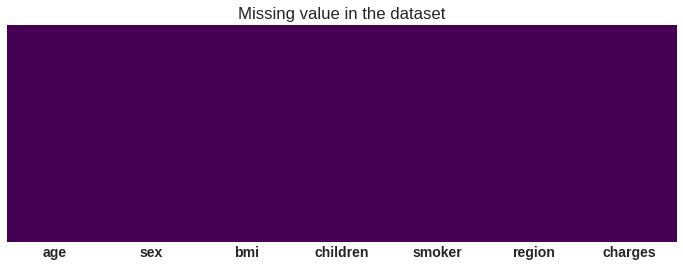

In [14]:
# Check for missing values
plt.figure(figsize=(12,4))
sns.heatmap(df.isnull(),cbar=False,cmap='viridis',yticklabels=False)
plt.title('Missing value in the dataset');

# No missing values!

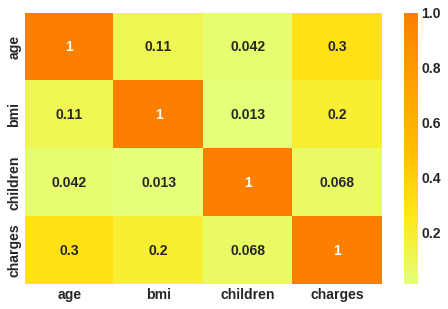

In [15]:
# Check for correlated variables
corr = df.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True);

# There doesn't seem to be any correlation between quantitative variables

Let's take a look at how our target variable behaves when segmented by our categorical variables

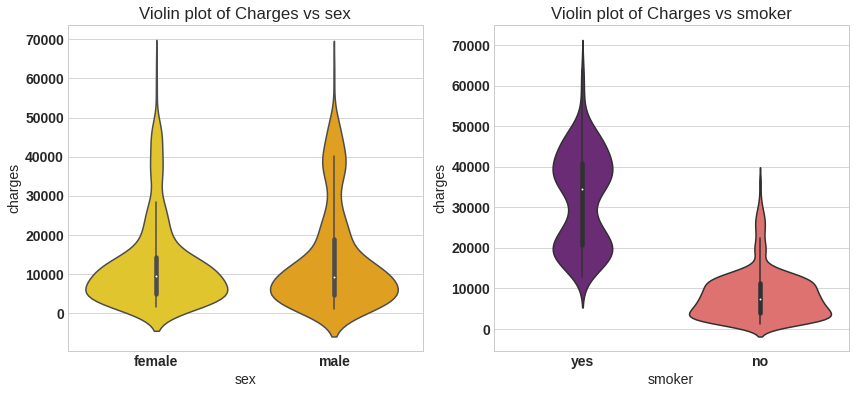

In [16]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='sex', y='charges',data=df,palette='Wistia',ax=ax)
ax.set_title('Violin plot of Charges vs sex')

ax = f.add_subplot(122)
sns.violinplot(x='smoker', y='charges',data=df,palette='magma',ax=ax)
ax.set_title('Violin plot of Charges vs smoker');

There's definitely a difference between the charges for smokers vs non-smokers. Gender doesn't seem to be too significant in terms of charges.

Next let's see how # of children affects the target variable:

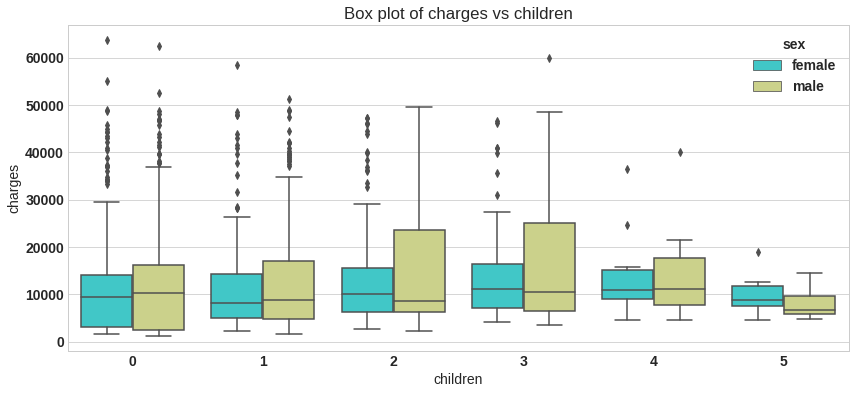

In [17]:
plt.figure(figsize=(14,6))
sns.boxplot(x='children', y='charges',hue='sex',data=df,palette='rainbow')
plt.title('Box plot of charges vs children');

In [21]:
print(df['children'].value_counts())

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64


Number of children doesn't seem to be significant, although there's some bias for samples where [# of children >= 4], although this might be caused by a smaller amount of samples for the latter ones. If this is the case, we might want to explore including all samples where [# of children] >= 3 in a single categorical bucket ("3 or more").

In [67]:
df['children_bucket'] = np.where(df['children'] == 0, 'child0',
                        np.where(df['children'] == 1, 'child1', 
                        np.where(df['children'] == 2, 'child2', 'child3+')))

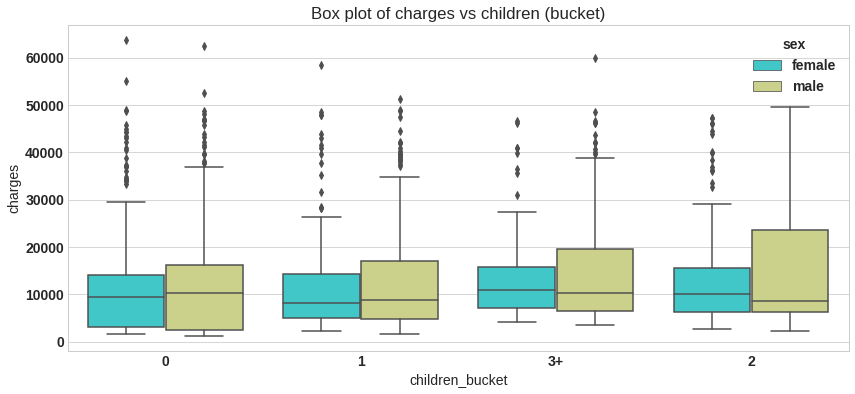

In [60]:
plt.figure(figsize=(14,6))
sns.boxplot(x='children_bucket', y='charges',hue='sex',data=df,palette='rainbow')
plt.title('Box plot of charges vs children (bucket)');

As expected, we have only a very small sample for values higher than 3 in [# of children] variable, so we'll explore creating a categorical variable out of the [children] original variable. This we'll explore after fitting our first model without any feature engineering.

Finally, let's explore some relationships between our quantitative variables, including a color dimension for our categorical variables: 

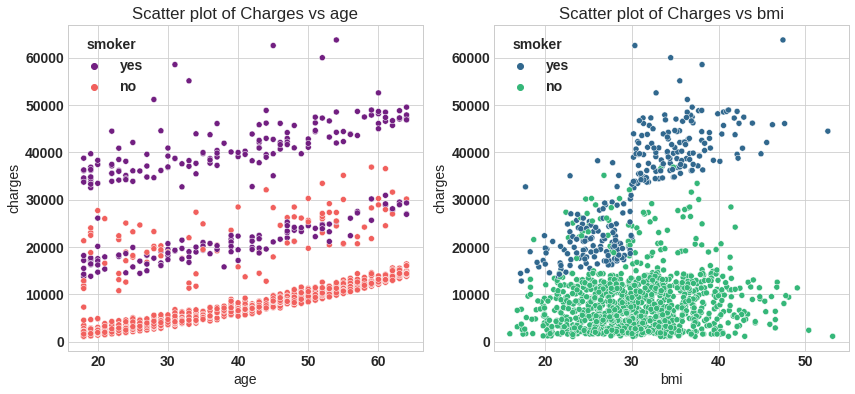

In [22]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df,palette='magma',hue='smoker',ax=ax)
ax.set_title('Scatter plot of Charges vs age')

ax = f.add_subplot(122)
sns.scatterplot(x='bmi',y='charges',data=df,palette='viridis',hue='smoker')
ax.set_title('Scatter plot of Charges vs bmi')
plt.savefig('sc.png');

There's a clear interaction between [smoker] and [bmi] that we'll want to include into the model. On the other hand there's a clear separation _within_ the smoker variable that is causing two clusters in charges. Otherwise it seems like there's a positive correlation between [age] and the target variable [charges] which seems to be pretty consistent among the different clusters (non-smokers, smokers cluster 1, and smokers cluster 2).

What could be causing this separation in the smokers group along the [charges] variable? As can be seen from the plot on the right, it seems like there's a hard cut between bmi less than 30 and bmi more than 30, so it might be a good idea to include such a variable into our model upfront. (In practice this is the kind of insights you'd get from the business understanding part of the data science pipeline).

In [77]:
df['bmi_more_than_30'] = np.where(df['bmi'] < 30, 0, 1)

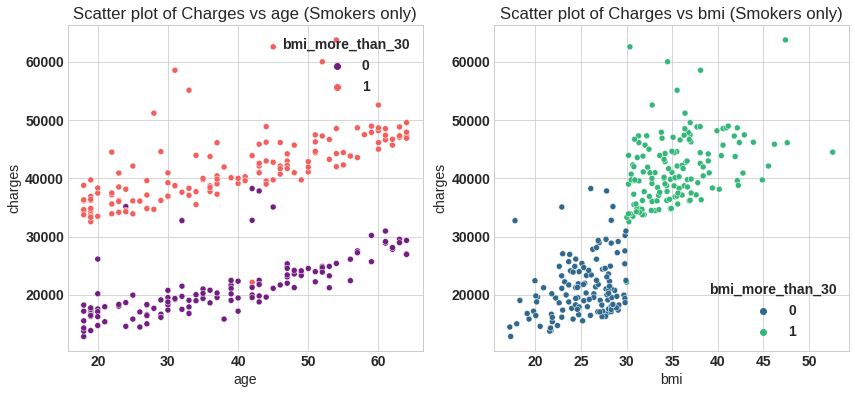

In [61]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='age',y='charges',data=df[df.smoker == "yes"],palette='magma',hue='bmi_more_than_30',ax=ax)
ax.set_title('Scatter plot of Charges vs age (Smokers only)')

ax = f.add_subplot(122)
sns.scatterplot(x='bmi',y='charges',data=df[df.smoker == "yes"],palette='viridis',hue='bmi_more_than_30')
ax.set_title('Scatter plot of Charges vs bmi (Smokers only)')
plt.savefig('sc.png');

We're now in a good place to try some models!

# Data preprocessing
We'll start by encoding categorical variables and splitting the data into a training set and a validation set:

In [78]:
# Dummy variable
categorical_columns = ['sex','children_bucket', 'smoker', 'region'] # we're not including the [bmi_more_than_30] variable since it's already encoded
df_encode = pd.get_dummies(data = df, prefix = 'cat', prefix_sep='_',
               columns = categorical_columns,
               drop_first =True,
               dtype='int8')

In [79]:
print(df_encode.head())

   age     bmi  children      charges  bmi_more_than_30  cat_male  cat_child1  \
0   19  27.900         0  16884.92400                 0         0           0   
1   18  33.770         1   1725.55230                 1         1           1   
2   28  33.000         3   4449.46200                 1         1           0   
3   33  22.705         0  21984.47061                 0         1           0   
4   32  28.880         0   3866.85520                 0         1           0   

   cat_child2  cat_child3+  cat_yes  cat_northwest  cat_southeast  \
0           0            0        1              0              0   
1           0            0        0              0              1   
2           0            1        0              0              1   
3           0            0        0              1              0   
4           0            0        0              1              0   

   cat_southwest  
0              1  
1              0  
2              0  
3              0  
4  

In [80]:
# Let's include the smoker AND high bmi interaction term
df_encode['cat_smoker_and_bmi30'] = df_encode['cat_yes'] * df_encode['bmi_more_than_30']

In [81]:
# Split data into training and test set
from sklearn.model_selection import train_test_split
X = df_encode.drop('charges',axis=1) # Independet variable
y = df_encode['charges'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

# Modeling
We'll try out first an OLS model with interaction between the [smoker] and [bmi_gt_30] variable, and [age].

Then we'll try out a Lasso without any sort of feature selection in order to see if we get the same result or better than the first one.

In [86]:
# Model 1
mod1_features = ['age','cat_yes', 'cat_smoker_and_bmi30']
X_train_1 = X_train[mod1_features]
X_test_1 = X_test[mod1_features]

# Scikit Learn module
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X_train_1,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
#sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
#parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
#parameter_df

LinearRegression()

In [98]:
# Evaluate my model
y_pred_1 = lin_reg.predict(X_test_1)

#   Evaluvation: MSE
from sklearn.metrics import mean_squared_error
J_mse_sk = mean_squared_error(y_pred_1, y_test)
print('R2 on test set: ',  str(lin_reg.score(X_test_1, y_test)))

R2 on test set:  0.8435694384878293


A 84% R2 doesn't seem too bad. We'll need to check if our assumptions hold, i.e. linearity, normality of the residuals and homoscedasticity. 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


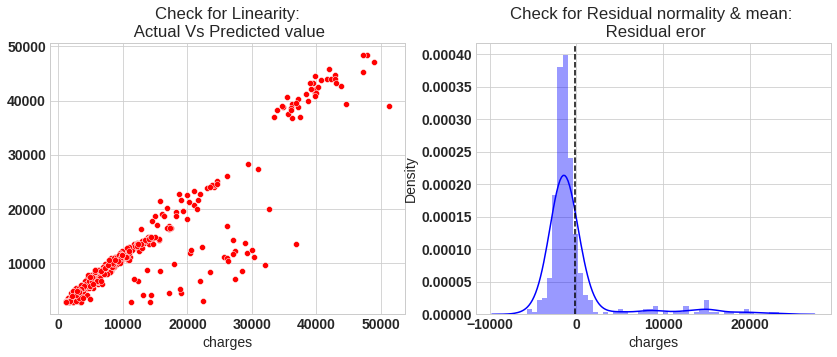

In [104]:
# Let's check out if our assumptions hold via residual analysis
# Check for Linearity
f = plt.figure(figsize=(14,5))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_1,ax=ax,color='r')
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_1),ax=ax,color='b')
ax.axvline((y_test - y_pred_1).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

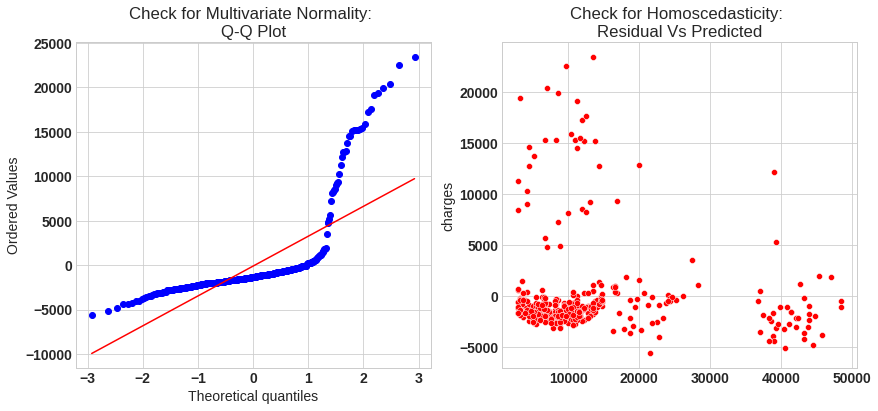

In [105]:
# Check for Multivariate Normality
# Quantile-Quantile plot 
f,ax = plt.subplots(1,2,figsize=(14,6))
import scipy as sp
_,(_,_,r)= sp.stats.probplot((y_test - y_pred_1),fit=True,plot=ax[0])
ax[0].set_title('Check for Multivariate Normality: \nQ-Q Plot')

#Check for Homoscedasticity
sns.scatterplot(y = (y_test - y_pred_1), x= y_pred_1, ax = ax[1],color='r') 
ax[1].set_title('Check for Homoscedasticity: \nResidual Vs Predicted');